In [1]:
import os

import astropy.table as at
from astropy.constants import G
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import thejoker as tj
import tables as tb

from gala.mpl_style import laguna, hesperia

from hq.config import Config
from hq.data import get_rvdata
from hq.physics_helpers import period_at_surface, stellar_radius

In [2]:
figure_path = '../../tex/figures'
os.makedirs(figure_path, exist_ok=True)

In [3]:
c = Config.from_run_name('dr16-random')

In [4]:
gold = at.QTable.read('../../catalogs/gold_sample.fits')
bimodal = at.QTable.read('../../catalogs/bimodal.fits')
bimodal = at.QTable(bimodal[bimodal['LOGG'] > -0.5], masked=False)

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


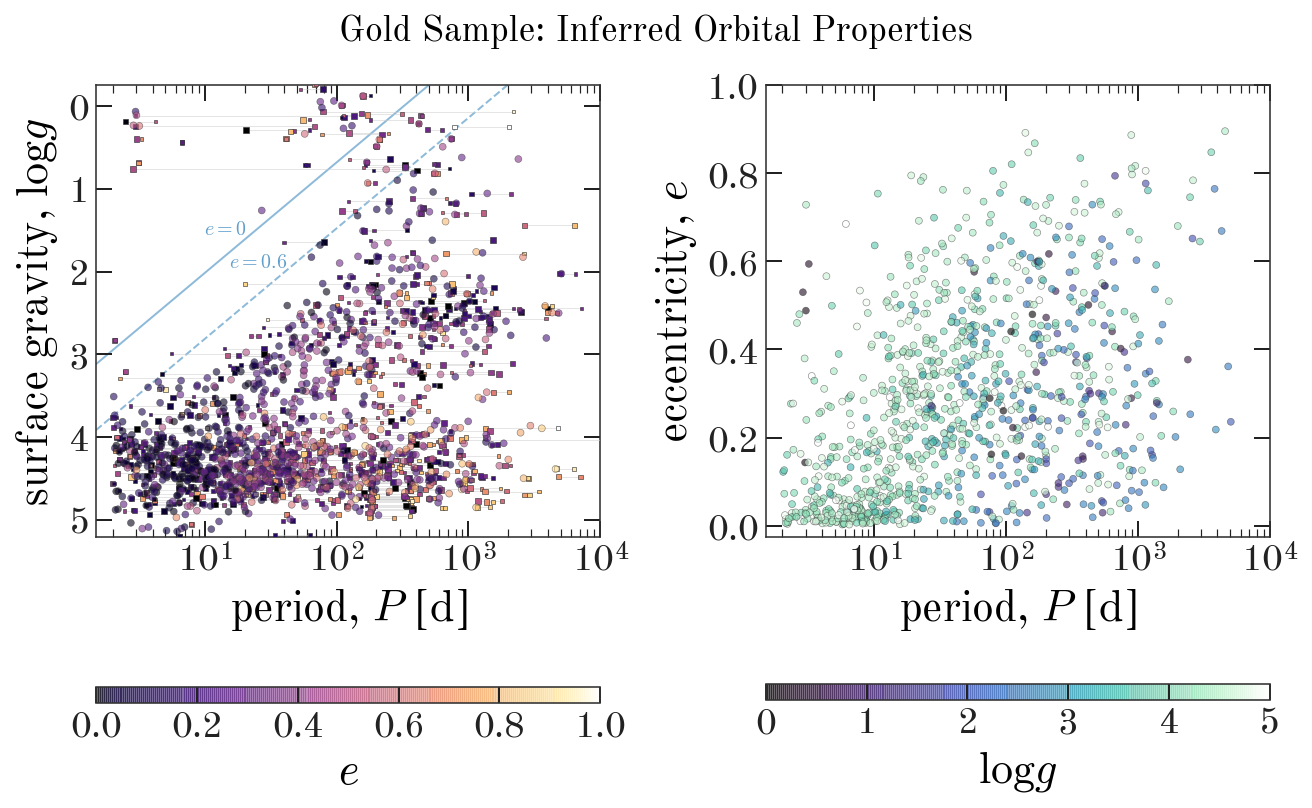

In [10]:
style = dict(s=12, lw=0.3, 
             edgecolor='#333333',
             alpha=0.6, zorder=10)

bi_style = dict(lw=0.3, marker='s', zorder=5, 
                edgecolor='#333333')

fig, axes = plt.subplots(1, 2, figsize=(9, 5.5), sharex=True, 
                         constrained_layout=True)

ax = axes[0]
im1 = ax.scatter(gold['MAP_P'], gold['LOGG'], 
           c=gold['MAP_e'], vmin=0, vmax=1, 
           cmap='hesperia',
           **style)

# TODO: do we want to show the bimodal on here?
for i in [0, 1]:
    ax.scatter(bimodal['MAP_P'][i::2],
               bimodal['LOGG'][i::2],
               c=bimodal['MAP_e'][i::2],
               s=((1 + bimodal['bimodal_mode_fraction'][i::2]) * 1.5)**2,
               cmap='hesperia',
               **bi_style)

ax.plot(np.stack((bimodal['MAP_P'][::2].value, 
                  bimodal['MAP_P'][1::2].value)), 
        np.stack((bimodal['LOGG'].filled()[::2], 
                  bimodal['LOGG'].filled()[1::2])), 
        marker='', linestyle='-', alpha=0.5, 
        color='#cccccc', zorder=3, linewidth=0.5)

logg_grid = np.linspace(-0.5, 6, 128)
M2 = 0.3 * u.Msun
M1 = 1.3 * u.Msun
for e, ls in zip([0., 0.6], ['-', '--']):
    ax.plot(period_at_surface(M1, logg_grid, e=e, M2=M2),
            logg_grid, 
            marker='', zorder=-10, alpha=0.5,
            color='tab:blue', lw=1., ls=ls)

ax.text(21, 1.6, '$e=0$', ha='right', va='bottom', color='tab:blue', alpha=0.7)
ax.text(42, 2, '$e=0.6$', ha='right', va='bottom', color='tab:blue', alpha=0.7)
    
ax.set_ylabel(r'surface gravity, $\log g$')
ax.set_xscale('log')
ax.set_ylim(5.2, -0.25)

ax = axes[1]
im2 = ax.scatter(gold['MAP_P'], gold['MAP_e'], 
           c=gold['LOGG'], vmin=0, vmax=5, 
           cmap='laguna',
           **style)

# for i in [0, 1]:
#     ax.scatter(bimodal['MAP_P'][i::2],
#                bimodal['MAP_e'][i::2],
#                c=bimodal['LOGG'][i::2],
#                s=((1 + bimodal['bimodal_mode_fraction'][i::2]) * 1.5)**2,
#                cmap='laguna',
#                **bi_style)

# ax.plot(np.stack((bimodal['MAP_P'][::2].value, 
#                   bimodal['MAP_P'][1::2].value)), 
#         np.stack((bimodal['MAP_e'][::2].value, 
#                   bimodal['MAP_e'][1::2].value)), 
#         marker='', linestyle='-', alpha=0.5, 
#         color='#cccccc', zorder=3, linewidth=0.5)

ax.set_ylabel(r'eccentricity, $e$')
ax.set_xscale('log')
ax.set_ylim(-0.025, 1)

for ax in axes:
    ax.set_xlabel(f'period, $P$ [{u.day:latex_inline}]')
    ax.set_xticks(10 ** np.arange(0, 4+1e-3))
    ax.set_xticks(np.concatenate([[j * 10**i for j in range(1, 10)] 
                                  for i in np.arange(0, 4+1e-3)]),
                  minor=True)
    ax.set_xlim(1.5, 1e4)
    
cb1 = fig.colorbar(im1, ax=axes[0], orientation='horiztontal', pad=0.07)
cb1.set_label('$e$')
cb1.set_ticks(np.arange(0, 1+1e-3, 0.2))

cb2 = fig.colorbar(im2, ax=axes[1], orientation='horiztontal', pad=0.07)
cb2.set_label(r'$\log g$')
cb2.set_ticks(np.arange(0, 5+1e-3, 1))

fig.suptitle('Gold Sample: Inferred Orbital Properties', fontsize=18)

fig.savefig(os.path.join(figure_path, 'Plogg_Pe.pdf'), dpi=250)

M2_min plots

In [12]:
from twobody.transforms import PeKi_to_a

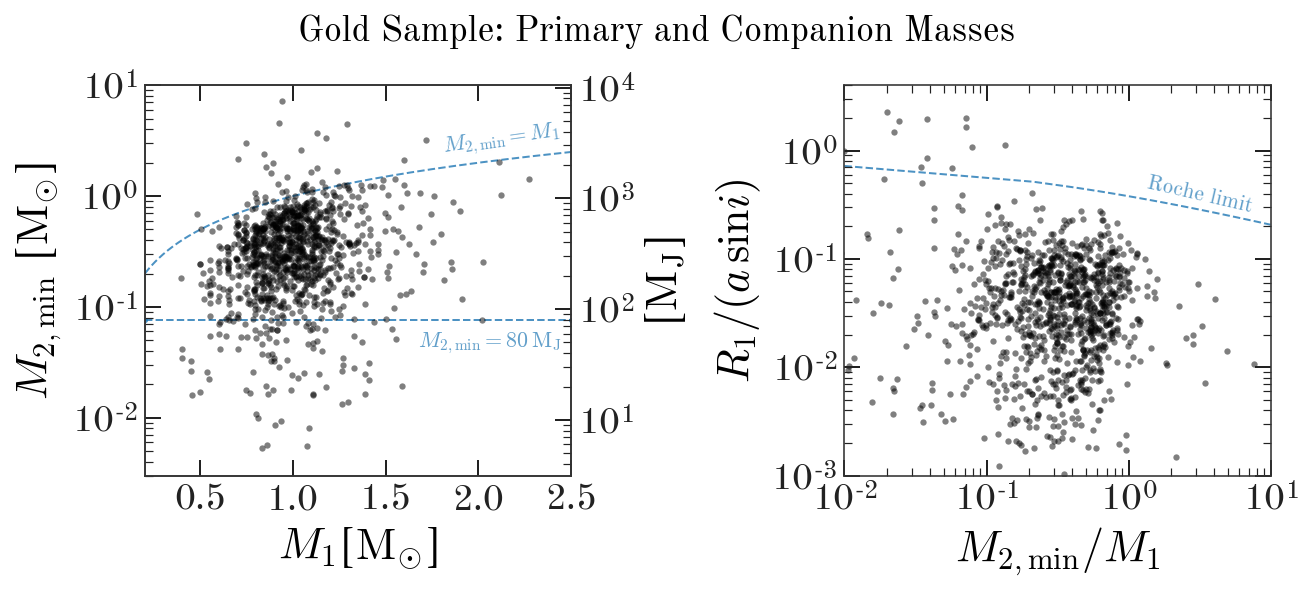

In [14]:
marker_style = dict(linewidth=0, s=10, alpha=0.5)
line_style = dict(zorder=-10, lw=1, color='tab:blue', 
                  linestyle='--', alpha=0.8)

fig, axes = plt.subplots(1, 2, figsize=(9, 4.),
                         constrained_layout=True)

ax = axes[0]

yerr = ((gold['m2_min_50'] - gold['m2_min_16']).value,
        (gold['m2_min_84'] - gold['m2_min_50']).value)
# ax.errorbar(gold['mass'], 
#             gold['m2_min_50'].value, 
#             xerr=gold['mass_err'],
#             yerr=yerr,
#             linestyle='', elinewidth=0.5, alpha=0.5)
ax.scatter(gold['mass'], 
           gold['m2_min_50'].value, 
           **marker_style)

mgrid = np.linspace(0.2, 2.5, 256)
ax.plot(mgrid, mgrid, marker='', **line_style)
ax.axhline((80*u.Mjup).to_value(u.Msun), 
           **line_style)

ax.set_xticks(np.arange(0.5, 2.5+1e-3, 0.5))

ax.set_xlim(0.2, 2.5)
ax.set_ylim(3e-3, 1e1)
ax.set_yscale('log')

ax.set_xlabel('$M_1$' + f'[{u.Msun:latex_inline}]')
ax.set_ylabel(r'$M_{2, {\rm min}}$ ' + f'[{u.Msun:latex_inline}]')

# Second y axis:
axr = ax.twinx()
ylim = ax.get_ylim()
axr.set_yscale('log')
axr.set_ylim((ylim[0]*u.Msun).to(u.Mjup).value, 
             (ylim[1]*u.Msun).to(u.Mjup).value)
axr.set_ylabel(f'[{u.Mjup:latex_inline}]')

ax.text(2.45, 2.1, r'$M_{2, {\rm min}} = M_1$', 
        ha='right', va='bottom', fontsize=11, 
        color='tab:blue', alpha=0.7, rotation=8)
ax.text(2.45, 0.062, r'$M_{2, {\rm min}} = 80\,{\rm M}_{\rm J}$', 
        ha='right', va='top', fontsize=11, 
        color='tab:blue', alpha=0.7)


# ------------------------------------

ax = axes[1]

qmin = gold['m2_min_50'].value / gold['mass']
Rstar = stellar_radius(gold['LOGG'], gold['mass']*u.Msun)
a1sini = PeKi_to_a(gold['MAP_P'], gold['MAP_e'], gold['MAP_K'])
asini = a1sini * (1 + 1/qmin)

ax.scatter(qmin, (Rstar/asini).decompose(), 
           **marker_style)

qgrid = np.linspace(1E-2, 1E1)
r1 = 0.49*qgrid**(-2/3.) / (0.6*qgrid**(-2/3.) + np.log(1+qgrid**(-1/3)))
ax.plot(qgrid, r1, marker='', **line_style)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks(10 ** np.arange(-2, 1+1e-3, 1))
ax.set_xticks(np.concatenate([[j * 10**i for j in range(1, 10)] 
                               for i in np.arange(-2, 1+1e-3)]),
              minor=True)

ax.set_xlim(1e-2, 1e1)
ax.set_ylim(1e-3, 4e0)

ax.text(1.3, 2.5e-1, 'Roche limit', rotation=-13,
        ha='left', va='bottom', fontsize=11, 
        color='tab:blue', alpha=0.7)

ax.set_xlabel(r'$M_{2, {\rm min}} / M_1$')
ax.set_ylabel(r'$R_1 / (a\,\sin i)$')

fig.suptitle('Gold Sample: Primary and Companion Masses', fontsize=18)

fig.savefig(os.path.join(figure_path, 'm2_m1_roche.pdf'), dpi=250)

---

In [6]:
alldata, allvisit = c.load_alldata()

In [11]:
low_mass = gold[(gold['m2_min_50'] < 50*u.Mjup) & (gold['m2_min_50'] > 10*u.Mjup)]
len(low_mass)

50

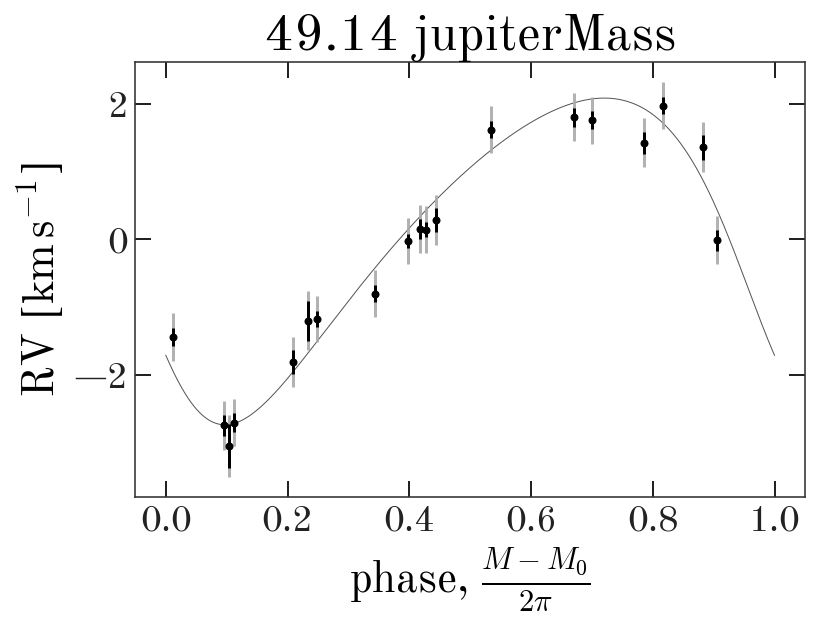

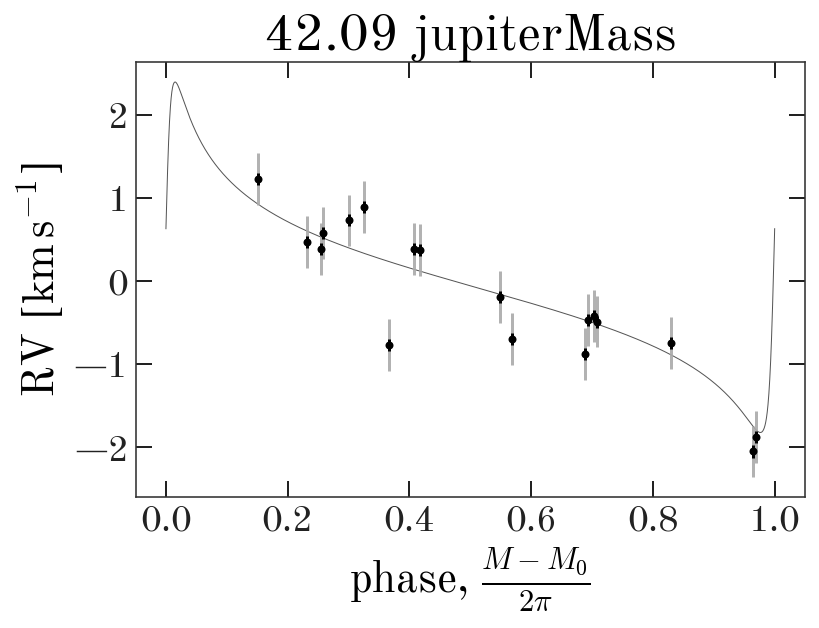

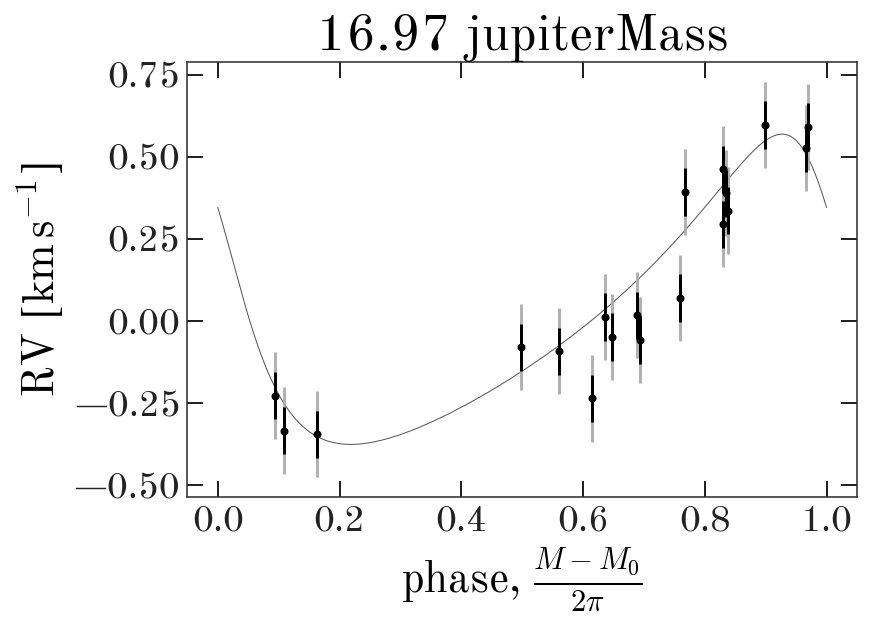

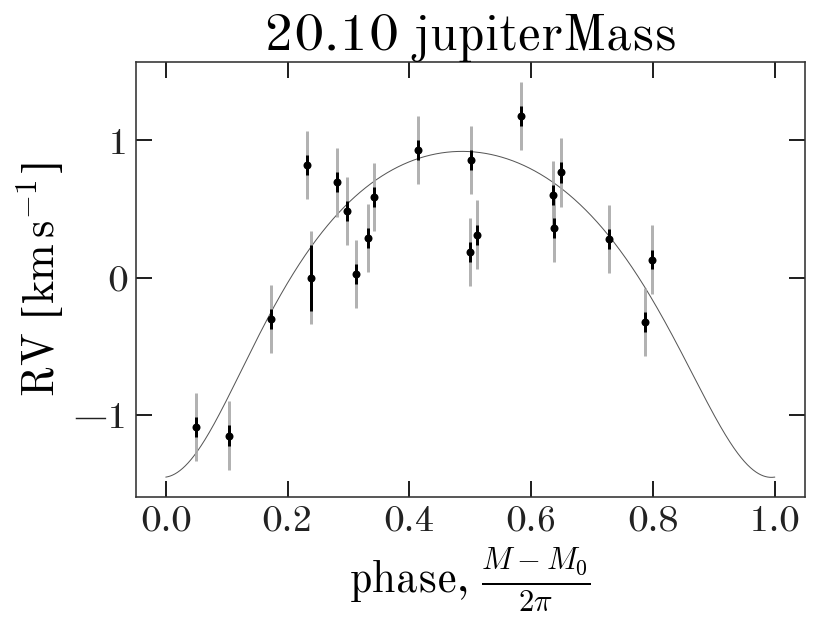

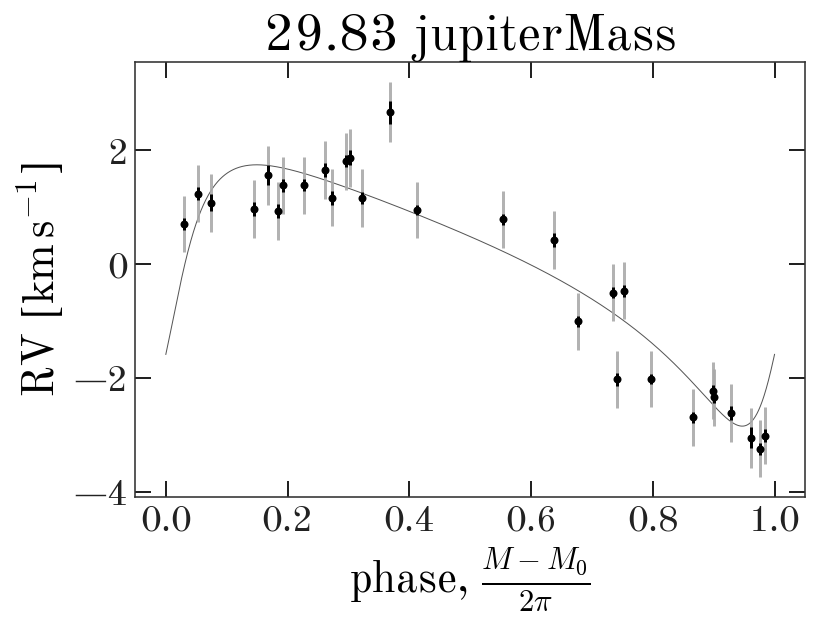

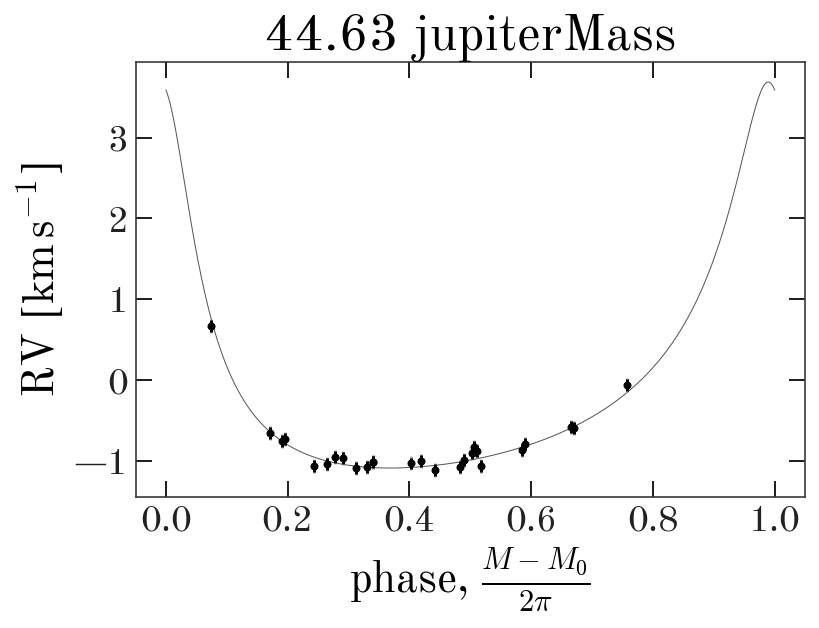

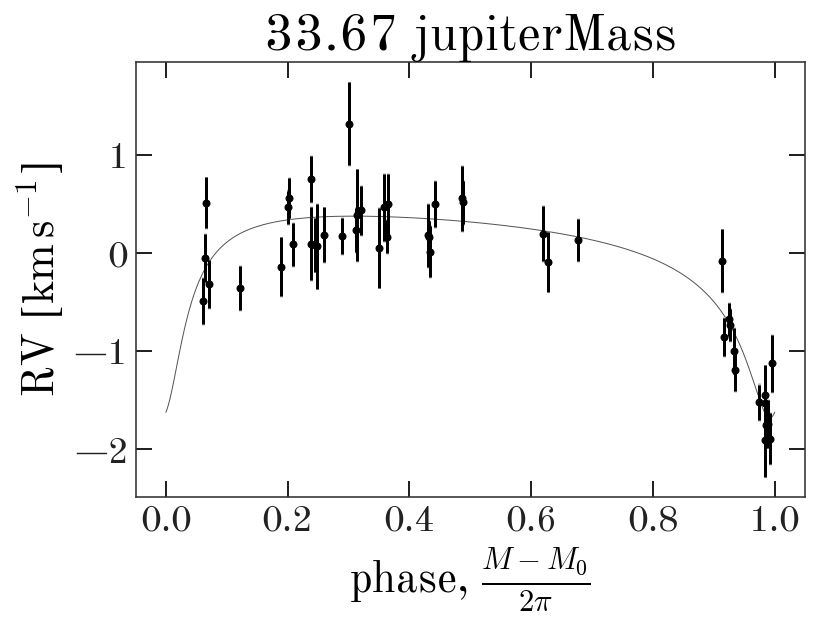

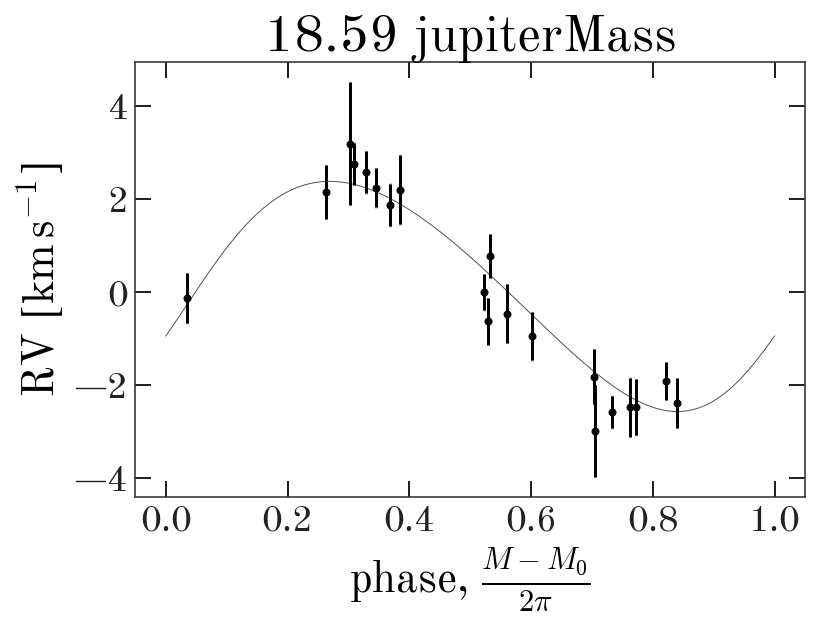

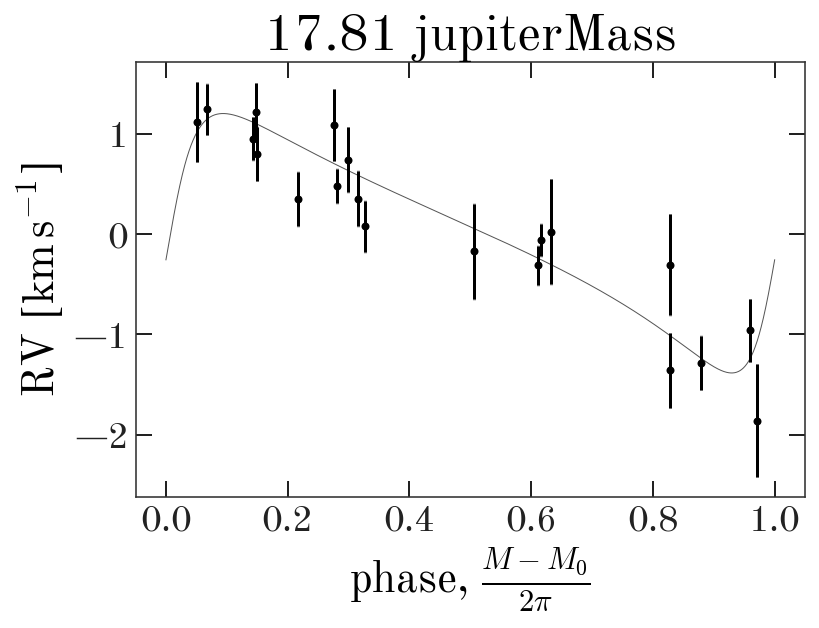

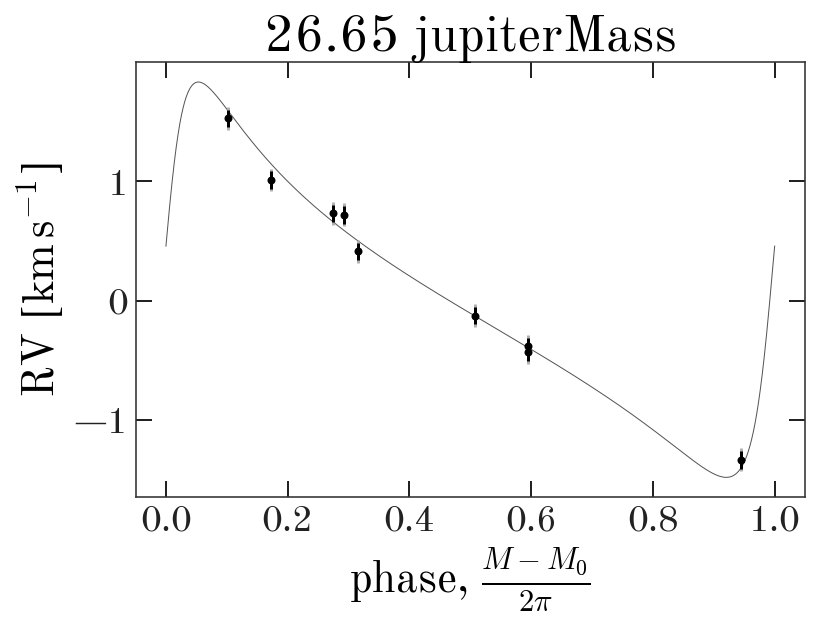

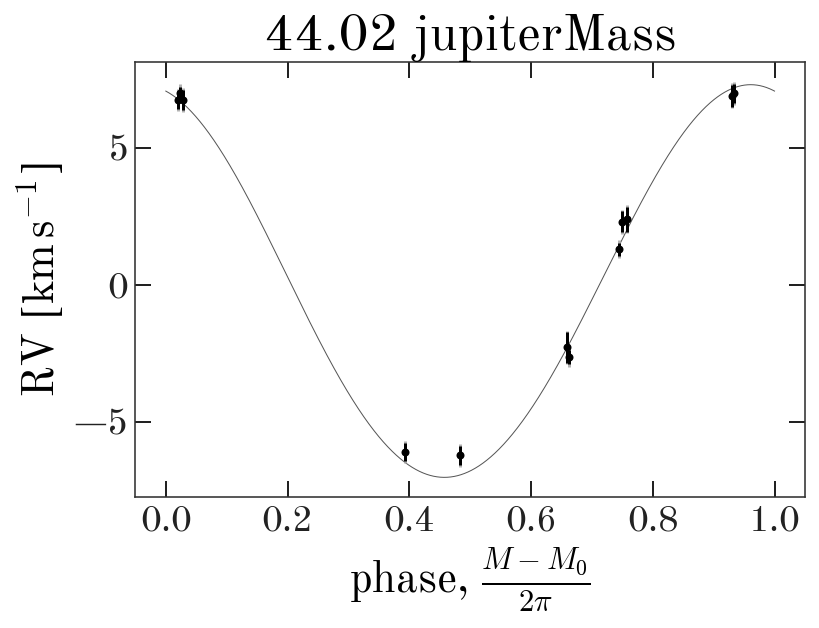

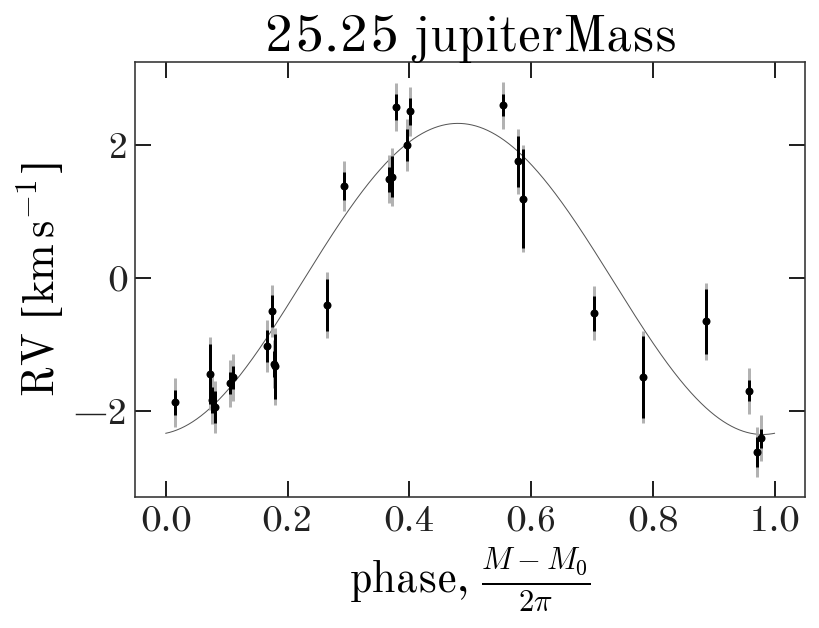

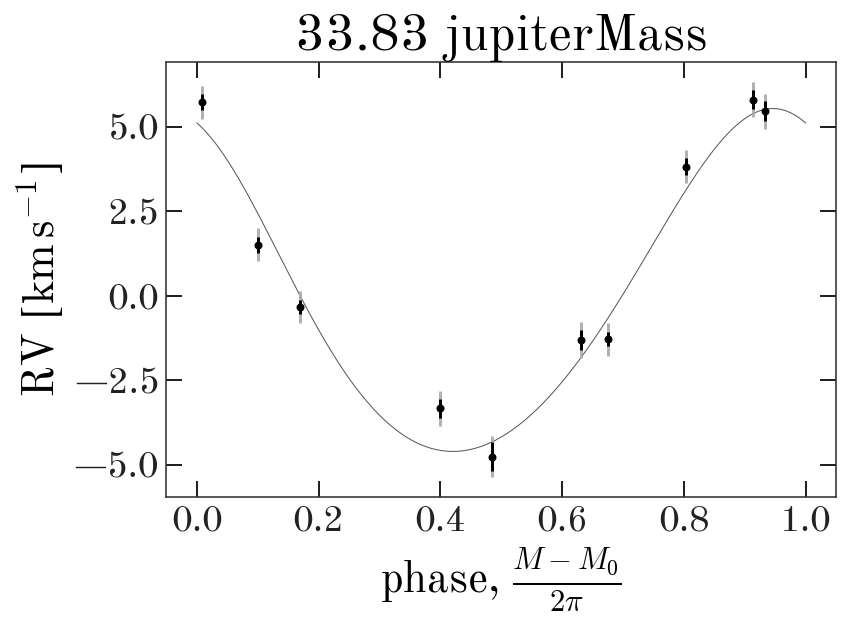

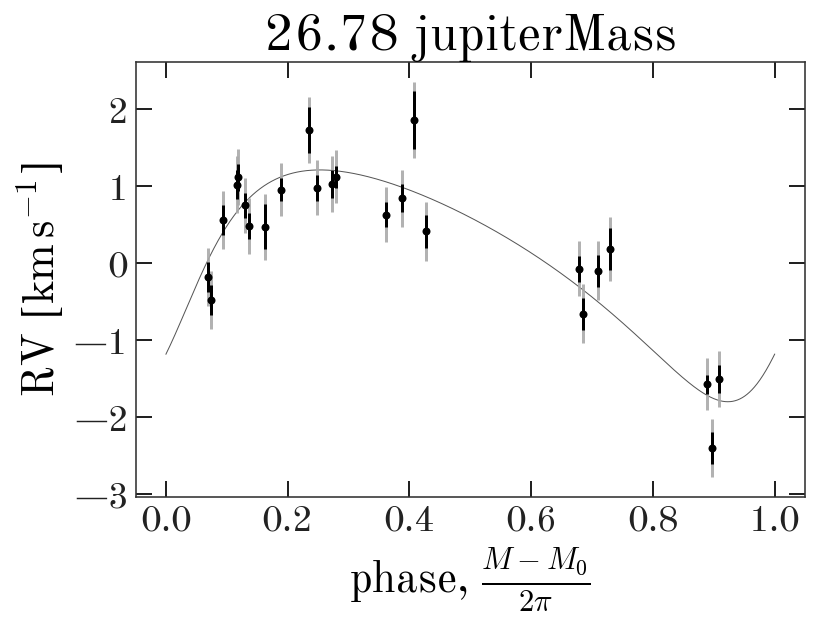

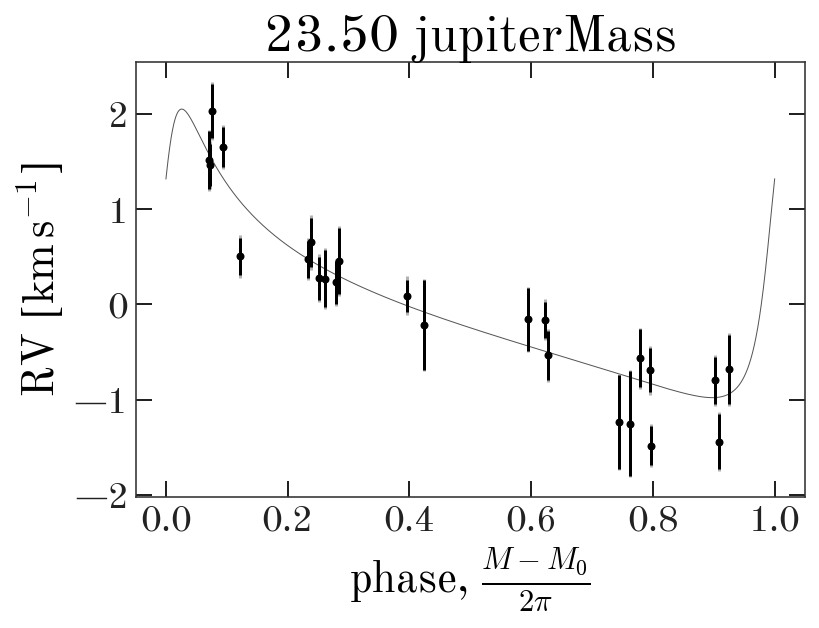

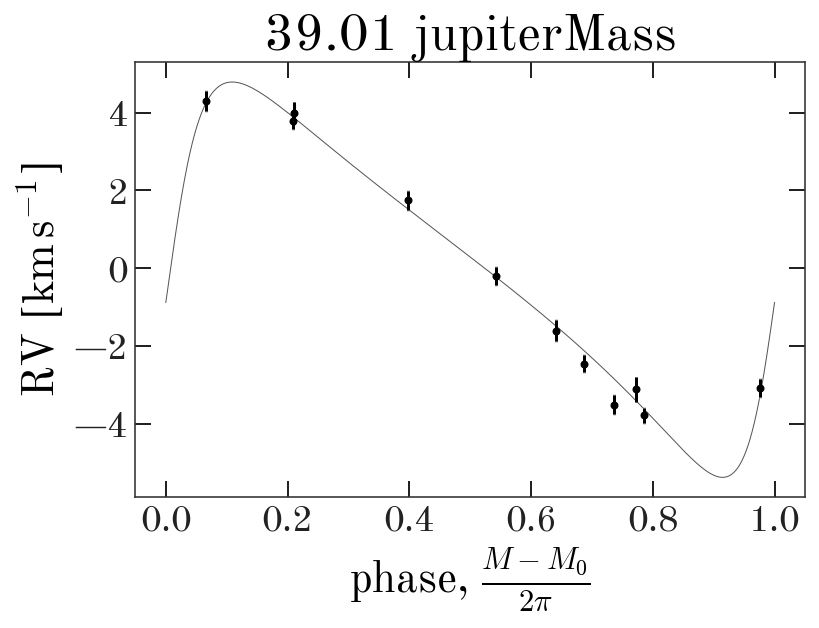

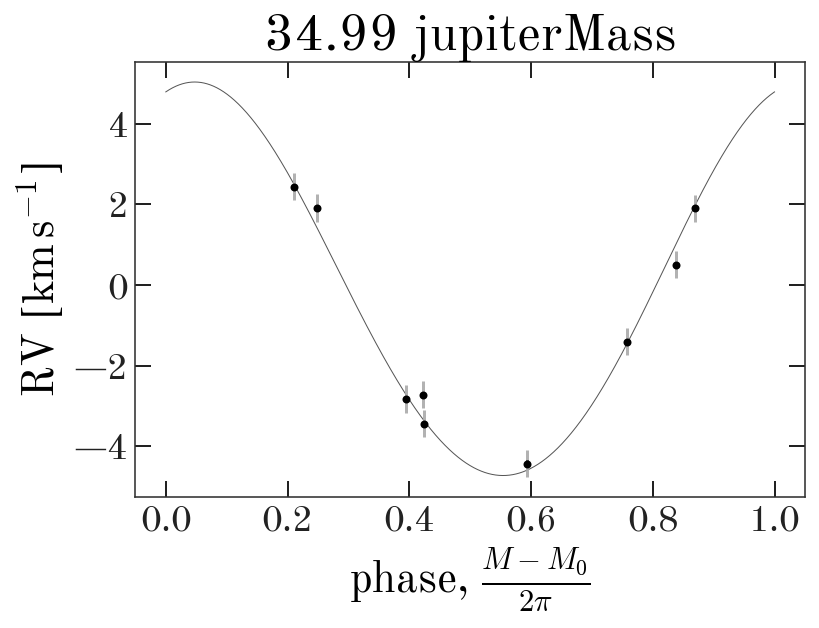

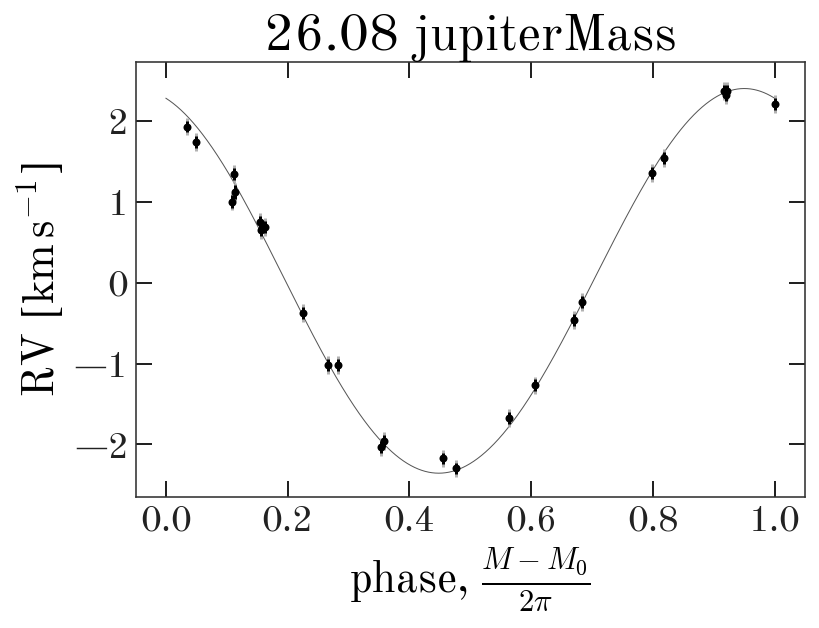

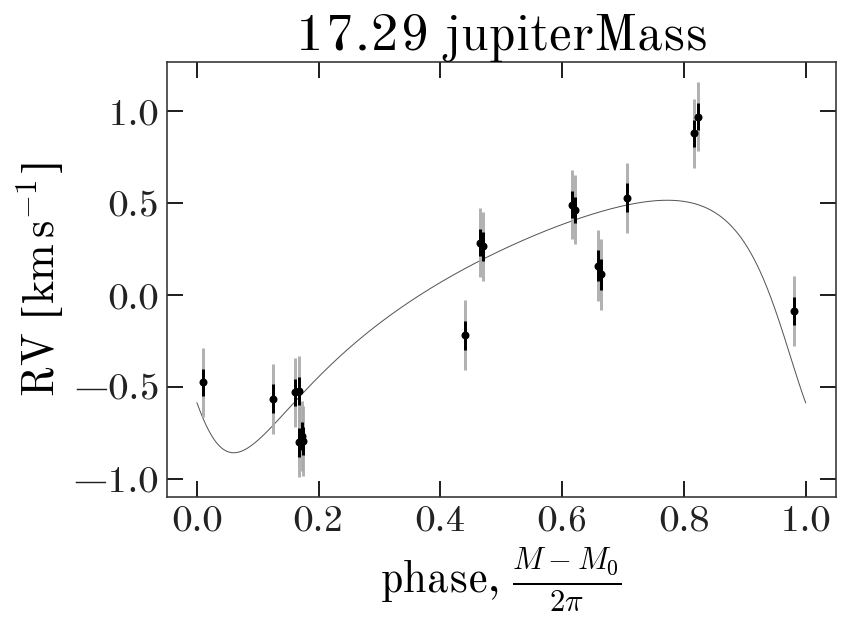

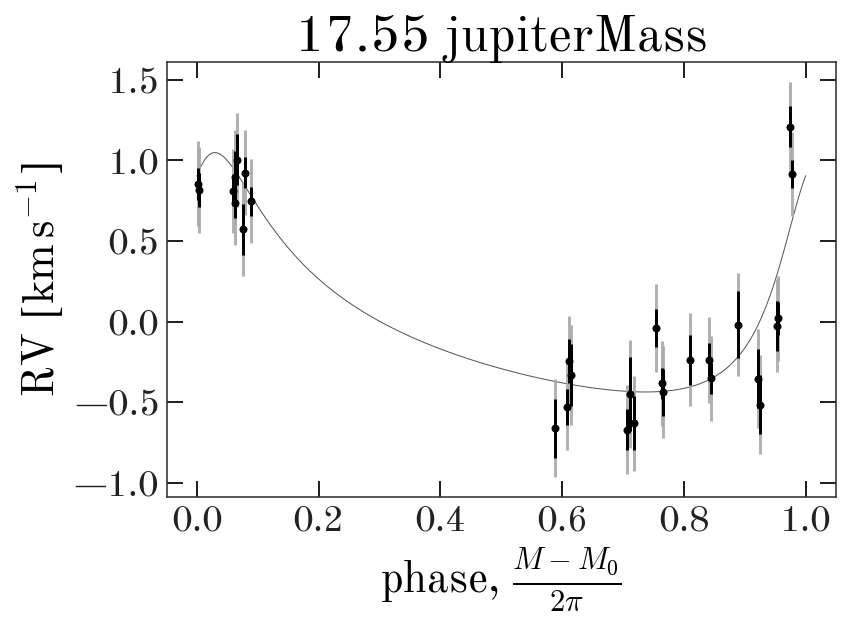

In [17]:
for row in low_mass[:20]:
    apid = row['APOGEE_ID']
    with h5py.File(c.mcmc_results_path, 'r') as f:
        samples = tj.JokerSamples.read(f[apid])
        data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == apid])
        
        # fig, ax = plt.subplots()
        # _ = tj.plot_rv_curves(samples[:16], data=data, ax=ax)
                
        fig, ax = plt.subplots()
        sample = samples.median()
        _ = tj.plot_phase_fold(sample, ax=ax, data=data)
        ax.set_title(f"{row['m2_min_50'].to(u.Mjup):.2f}")